In [1]:
%pip install lenskit
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn
import time

In [3]:
import pandas as pd

In [4]:
# ratings = pd.read_csv('/scratch/work/courses/DSGA1004-2021/movielens/ml-latest-small/ratings.csv')
ratings_train = pd.read_parquet('train_combined_large_set.parquet')
ratings_val = pd.read_parquet('val_large_set.parquet')

FileNotFoundError: [Errno 2] No such file or directory: 'train_combined_large_set.parquet'

In [46]:
ratings_train

,userId,movieId,rating,timestamp
0,2,318,3.0,1445714835
1,2,333,4.0,1445715029
2,2,1704,4.5,1445715228
3,2,3578,4.0,1445714885
4,2,6874,4.0,1445714952
...,...,...,...,...
70278,315,599,4.0,939919421
70279,315,909,5.0,939919421
70280,315,924,3.0,939919421
70281,315,1207,5.0,939919421


In [47]:
ratings_train.columns = ratings_train.columns.str.replace('userId', 'user')
ratings_train.rename(columns = {'userId':'user', 'movieId':'item'}, inplace = True)
ratings_val.columns = ratings_val.columns.str.replace('userId', 'user')
ratings_val.rename(columns = {'userId':'user', 'movieId':'item'}, inplace = True)

In [48]:
ratings_val

,user,timestamp,item,rating
0,463,1145459479,3448,3.0
1,463,1145460004,5378,4.0
2,463,1145460012,1690,4.0
3,463,1145460019,1552,4.5
4,463,1145460023,3753,4.0
...,...,...,...,...
15069,422,1010279788,2670,3.0
15070,422,1010279788,2841,3.0
15071,422,1010279788,3157,3.0
15072,422,1010279817,2070,4.0


In [55]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50,iterations=15)

In [56]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [57]:

start_time = time.time()

rec_item = eval('ItemItem',algo_ii, ratings_train, ratings_val)
rec_ALS = eval('ALS', algo_als, ratings_train, ratings_val)
    
    
finish_time = time.time()
print("----- %s seconds -----", finish_time - start_time)

----- %s seconds ----- 12.197755575180054


In [58]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results_ALS = rla.compute(rec_ALS, ratings_val)
results_ALS.head()

nrecs      ndcg
Algorithm user                 
ALS       463     100  0.130072
          516     100  0.034277
          65      100  0.152302
          588     100  0.206783
          78      100  0.093779

In [59]:
results_ALS.groupby('Algorithm').ndcg.mean()

Algorithm
ALS    0.098651
Name: ndcg, dtype: float64

<AxesSubplot:xlabel='Algorithm'>

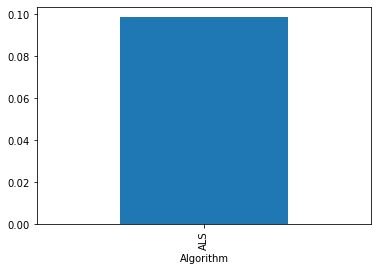

In [60]:
results_ALS.groupby('Algorithm').ndcg.mean().plot.bar()